## Implementation of Deep Q-learning Neural-network (DQN) in a multi-agent setting

A component of the coursework submitted for module "Multi-Agent AI".

A DQN is implemented to solve the Switch2 and Switch4 games, the environments for which are provided here: https://github.com/koulanurag/ma-gym/wiki/Environments#Switch


### Environment Example
#### Switch2-v0
![Switch-2](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch2-v0.gif)
#### Switch4-v0
![Switch-4](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch4-v0.gif)

The switch environment is described as follows:

`Switch-n` is a grid world environment having `n agents` where each agent wants to move their corresponding home location (marked in boxes outlined in same colors).
Each agent receives only it's local position coordinates. The challenging part of the game is to pass through the narrow corridor through which only one agent can pass at a time. They need to coordinate to not block the pathway for the other. A reward of +5 is given to each agent for reaching their home cell. The episode ends when both agents has reached their home state or for a maximum of 100 steps in environment.

Action Space: `0: Down, 1: Left, 2: Up , 3: Right, 4: Noop`

Agent Observation : `Agent Coordinate + Steps in env.`

Best Score: `NA`

### Download Requirements and Set the Environment
The following command will download the required scripts and set up the environment. 

In [1]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 

!pip install -q -e . 

!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 955 (delta 4), reused 17 (delta 3), pack-reused 931
Receiving objects: 100% (955/955), 3.71 MiB | 28.58 MiB/s, done.
Resolving deltas: 100% (467/467), done.
/content/ma-gym
ERROR: unknown command "update"
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.2)


In [2]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Example of playing Switch2-v0 Using Random Policy

In [3]:
env = wrap_env(gym.make("Switch2-v0")) 
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()

while not all(done_n):
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample()) # this gives a random action between 0 and 4 for each agent. 
    ep_reward += sum(reward_n)
    env.render()
env.close()

# To improve the training efficiency, render() is not necessary during the training.
# Render and video code provided here to demonstrate debugging and analysis.
show_video()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#### Code for Playing Switch2-v0 with a DQN


In [6]:
import torch
from torch import nn

import torch.nn.functional as func
import random
import torch.optim as optim

import numpy as np

from collections import deque


# NN definition
class DQN(nn.Module):

    def __init__(self, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        fc1_output_nodes=64
        fc2_output_nodes=64

        #Three fully connected layers
        # input: 9. 1 x current state, 3 x history states and current step 
        # output: 5 - number of actions

        self.fc1 = nn.Linear(9, fc1_output_nodes) 
        self.fc2 = nn.Linear(fc1_output_nodes, fc2_output_nodes)
        self.out = nn.Linear(fc2_output_nodes, 5)
        

    def forward(self, x):
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x= self.out(x)
        return x


class SwitchAgent:

    def __init__(self,batch,buffer,eps,eps_rate,M,C,gamma,max_iterations,seed):

        # DQNs
        self.DQN_local = DQN(seed)   
        self.DQN_target = DQN(seed)  
        self.seed = random.seed(seed)

        # Optimizer (concerns backpropagation)
        self.optimizer = optim.Adam(self.DQN_local.parameters(),lr=0.0005)

        #Experiences replay
        self.batch=batch
        self.experiences=deque(maxlen=buffer)

        # Parameter set up
        self.eps=eps
        self.eps_rate=eps_rate
        self.iteration=0
        self.iteration_count_M=self.iteration
        self.M_frequency=M
        self.iteration_count_C=self.iteration
        self.C_frequency=C
        self.gamma=gamma
        self.max_iterations=max_iterations



    def act(self, observation, exploration):

       
        observation=torch.from_numpy(np.array(observation)).float()

        # Forward pass NN, get Q values 
        Q=self.DQN_local(observation).detach().numpy()  

        # If training - select according to eps greedy  
        if (random.random() < self.eps) and (exploration): 
            action=random.choice(np.arange(5)) 

        else:
            pi = (Q == np.max(Q)).astype(np.double)
            pi /= np.sum(pi)
            action=np.random.choice((pi).size, size=1, p=pi)[0] 
      
        self.iteration=self.iteration+1;
        return (action)
        
    def update(self, observation, action, reward, observation_next, done):
    
    # See reference [2] Algorithm 1 for DQN algorithm 

    # rollout function has stepped, now update occurs:

      # 1. Append new experience
      self.experiences.append((observation, action, reward, observation_next, done))
      
      # 2. Qlearn every M steps 
      self.iteration_count_M=(self.iteration_count_M+1) % self.M_frequency

      if ((self.iteration_count_M ==0) and (len(self.experiences) > self.batch)):

          # 3. Take Random sample for Replay
          sampled_experiences=np.array(random.sample(self.experiences, k=self.batch))

          observation      =torch.from_numpy(np.vstack(sampled_experiences[:,0])).float()
          action           =torch.from_numpy(np.vstack(sampled_experiences[:,1])).long()
          reward           =torch.from_numpy(np.vstack(sampled_experiences[:,2])).float()
          observation_next =torch.from_numpy(np.vstack(sampled_experiences[:,3])).float()
          done             =torch.from_numpy(np.vstack(sampled_experiences[:,4])).int()
          
          # 4. Learn 

          # Forward pass NN, get Q values 
          Q_target_next=self.DQN_target((observation_next)).detach().max(1)[0].unsqueeze(1)

          # 5. Loss

          # This updates when done 
          Q_target=reward + (self.gamma * Q_target_next * (1 - done))
          Q_expected=self.DQN_local(observation).gather(1,action)
          loss = func.mse_loss(Q_expected, Q_target)
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # 6. According to C, update target Q with a combination of local (majority i.e. C) and target (minimal i.e 1-C)
          C = 1e-3
          for target_param, local_param in zip(self.DQN_target.parameters(), self.DQN_local.parameters()):
            target_param.data.copy_(C*local_param.data + (1.0-C)*target_param.data)


# Rollout function for the switch game
def rolloutSwitch(env, agents, exploration=True, max_iter=5000, log_episode_interval=100):
  history_reward = []
  state_n = env.reset()
  num_agents=len(agents)

  # initial state is at rest
  # setting up previous state placeholders
  prevstate_n = state_n 
  prevstate2_n = state_n
  prevstate3_n = state_n 

  episode_reward = 0
  total_reward=np.zeros(num_agents)
  episode_count = 0
  done_episode_count =0
  recorded_episodes = []
  recorded_episode_reward = []
  step=0

  for i in range(max_iter):

      actions = np.array([agent.act(state+prevstate+prevstate2+prevstate3+[(step/50)], exploration) for state, prevstate, prevstate2, prevstate3, agent in zip(state_n, prevstate_n, prevstate2_n, prevstate3_n, agents)])

      #Take a step
      next_state_n, reward_n, done_n, info = env.step(actions)
      episode_reward += np.sum(reward_n)
      
      for j, (state, prevstate, prevstate2, prevstate3, reward, next_state, done, agent) in enumerate(zip(state_n, prevstate_n, prevstate2_n, prevstate3_n, reward_n, next_state_n, done_n, agents)):
          total_reward[j]=total_reward[j]+reward
          reward=sum(reward_n)

          # Update only if exploring (i.e. learning)  
          if exploration == True:
            agent.update(state + prevstate + prevstate2 + prevstate3 + [(step/50)], actions[j], reward, next_state + state + prevstate + prevstate2 + [((step+1)/50)], done)


      prevstate3_n = prevstate2_n
      prevstate2_n = prevstate_n
      prevstate_n = state_n
      state_n = next_state_n

      if np.all(done_n):
        if not exploration:
          print("Episode: "+str(done_episode_count))

          if len(agents)==2:
            print("The Target Coordinates are: [[0.0, 1.0], [0.0, 0.0]]")

          if len(agents)==4:
            print("The Target Coordinates are: [[0.0, 1.0], [0.0, 0.0], [1.0, 1.0], [1.0, 0.0]]")
          print("The final coordinates after test are: "+str(state_n))
          print("The final reward for each agent is: "+str(total_reward))
          done_episode_count=done_episode_count+1
          env.render()
        
        #Reset Step at Done
        step=0

        #Anneal eps at every episode
        switch_agent.eps=max(switch_agent.eps*switch_agent.eps_rate,0.01)  

        state_n = env.reset()
        prevstate_n = state_n 
        prevstate2_n = state_n
        prevstate3_n = state_n

        history_reward.append(episode_reward)

        if not exploration:
          env.close()

        total_reward=np.zeros((num_agents))
    
        episode_reward = 0
        episode_count += 1
        if (episode_count + 1) %  log_episode_interval == 0:
          recorded_episodes.append(i)
          episodes_total_reward = np.sum(history_reward)
          episodes_mean_reward = np.mean(history_reward)
          recorded_episode_reward.append(episodes_mean_reward)
          history_reward = []
          
      step=step+1;
  
  if not exploration:
    show_video()

  return recorded_episodes, recorded_episode_reward


#### Train

In [7]:


env = wrap_env(gym.make("Switch2-v0"))
agent_num = env.n_agents
action_num = len(env.action_space)
switch_agents = []
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0
obs_n = env.reset()

max_iterations=300000 

for i in range(agent_num):
    switch_agent = SwitchAgent(batch=4,buffer=100,eps=1,eps_rate=0.995,M=4,C=100,gamma=0.99,max_iterations=max_iterations, seed=8)
    switch_agents.append(switch_agent)
    
    
# Training
train_recorded_episodes, train_recorded_episode_reward = rolloutSwitch(env=env, 
                                                                 agents=switch_agents, 
                                                                 exploration=True, 
                                                                 max_iter=max_iterations,
                                                                 log_episode_interval=1) 






/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Plot Learning Curve

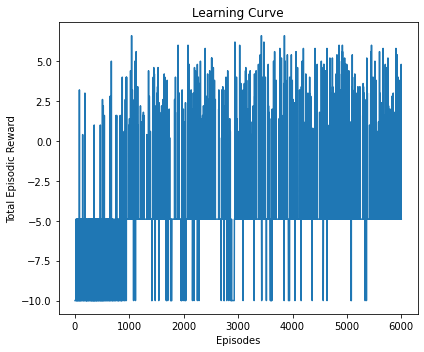

In [8]:
# Plot the Learning Curve 


fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

summerised_train_recorded_episode_reward = train_recorded_episode_reward
ax.plot(np.divide(train_recorded_episodes,50), train_recorded_episode_reward)

ax.set_title("Learning Curve")
ax.set_ylabel("Total Episodic Reward")
ax.set_xlabel("Episodes")
plt.tight_layout()
plt.show()


In [10]:
#Testing (therefore no exploration)

env = wrap_env(gym.make("Switch2-v0"))
test_recorded_episodes, test_recorded_episode_reward = rolloutSwitch(env=env, 
                                                                 agents=switch_agents, 
                                                                 exploration=False, 
                                                                 max_iter=55,
                                                                 log_episode_interval=1) 


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 0
The Target Coordinates are: [[0.0, 1.0], [0.0, 0.0]]
The final coordinates after test are: [[0.0, 1.0], [0.0, 0.0]]
The final reward for each agent is: [3. 3.]
Episode: 1
The Target Coordinates are: [[0.0, 1.0], [0.0, 0.0]]
The final coordinates after test are: [[0.0, 1.0], [0.0, 0.0]]
The final reward for each agent is: [3.1 3.1]


#### Analysis on performance

**Implementation**

In this game ‘Switch’, the agents interact with the switch environment through  actions, observations (or states) and rewards. The aim is for each agent to learn an action value function Q(s,a). However, in problems where there are a great number of actions and states, it is not feasible from a perspective of computation and memory to generate the Q [s,a] table using basic Q-learning. Therefore, a Deep Q-learning Neural-network (DQN) is implemented to estimate Q(s,a), as based on the original DQN demonstrated by Google DeepMind [2].

The neural network architecture is implemented in the initialisation of class ‘DQN’ and consists of an input layer of size 8, two hidden layers each of 64 and an output layer of 5 corresponding to each of the possible actions. The input layer consists of the current state, current step number and 3 previous states as discussed in [2] such that learning can be carried out. This NN is a simplification of that from reference [2] given that the input is quantified as solely as state coordinates and step, as opposed to in the form of images where convolution is required. 

The ‘act’ function in class ‘SwitchAgent’ selects an action when in learning mode based on an ‘epsilon-greedy’ exploration technique. An initial value of 1 is selected to promote initial exploration, this is then annealed at every episode to a minimum of 0.1 for exploitation.  

In reinforcement learning using neural networks there is the potential for instability due to correlations between observations, small updates to Q significantly changing policy and correlations between action and target values of Q. Reference [2] proposes two methods to mitigate this instability, both of which are implemented in the ‘update’ function of class ‘SwitchAgent’. Firstly, a method called ‘Experience Replay’ samples a batch randomly from a buffer of experiences (consisting of state, action, reward and next state) which are then used for learning every M steps. This has the effect of reducing correlations between observations. Secondly, the target Q values are updated partially (as governed by C in this code) at each learning step to reduce correlations between action and target values. 

**Assessment**

The learning curve demonstrates an improvement in total episodic reward at increasing number of episodes. Note that a total reward above -5 indicates one agent reached the goal, as is consistently obtained at approximately 1000 episodes and that a total reward of 0 indicates that both agents reached the final goal, as occurs more frequency with increasing episodes. The test result rewards, coordinates and video demonstrate a succesful test. 

Note that although succesful, the test (and therefore implementation) has not provided the best result. In an optimal scenario agent 1 can reach its goal in 7 steps (reward of 5 - 0.1 x 7 = 4.3) and agent 2 in 12 steps (reward of 5 - 0.1 x 12 = 3.8) after waiting for the 1st agent to proceed through the corridor. 

Note that hyperparameters in this implementation are selected based on those presented by [2], with simplifications considering the smaller input into the neural network, for example the batch size reduced from 32 to 4. Informal adjustments were then performed, due to the high computational cost of a hyperparameter search. However, improved results may be achieved with a systematic search. Similarly, results may improve with futher training.


[2] Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A.A., Veness, J., Bellemare, M.G., Graves, A., Riedmiller, M., Fidjeland, A.K., Ostrovski, G. and Petersen, S., 2015. Human-level control through deep reinforcement learning. Nature, 518(7540), pp.529-533.



#### Playing Switch4-v0 with a DQN

In [ ]:
env = wrap_env(gym.make("Switch4-v0"))
agent_num = env.n_agents
action_num = len(env.action_space)
switch_agents = []
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0
obs_n = env.reset()

max_iterations=300000 

for i in range(agent_num):
    switch_agent = SwitchAgent(batch=4,buffer=100,eps=1,eps_rate=0.9992,M=4,C=100,gamma=0.99,max_iterations=max_iterations, seed=8)
    switch_agents.append(switch_agent)
    
    
# Training
train_recorded_episodes, train_recorded_episode_reward = rolloutSwitch(env=env, 
                                                                 agents=switch_agents, 
                                                                 exploration=True, 
                                                                 max_iter=max_iterations,
                                                                 log_episode_interval=1) 



/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#### Plot the Learning Curve

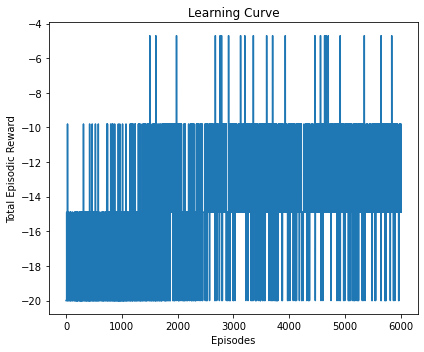

In [ ]:
# Plotting

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

ax.plot(np.divide(train_recorded_episodes,50), train_recorded_episode_reward)

ax.set_title("Learning Curve")
ax.set_ylabel("Total Episodic Reward")
ax.set_xlabel("Episodes")
plt.tight_layout()
plt.show()



In [ ]:
env = wrap_env(gym.make("Switch4-v0"))

#Testing
test_recorded_episodes, test_recorded_episode_reward = rolloutSwitch(env=env, 
                                                                 agents=switch_agents, 
                                                                 exploration=False, 
                                                                 max_iter=55,
                                                                 log_episode_interval=1) 



/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 0
The Target Coordinates are: [[0.0, 1.0], [0.0, 0.0], [1.0, 1.0], [1.0, 0.0]]
The final coordinates after test are: [[0.0, 1.0], [0.0, 0.0], [1.0, 1.0], [1.0, 0.0]]
The final reward for each agent is: [2. 2. 2. 2.]


#### Analysis on Performance

Given the added complexity with more agents, the epsilon annealing rate is increased in order to allow for increased exploration. A rate of 0.995 is applied in the 2 player case, when this was increased to 0.999 the test case showed agent 2 and 4 succesfully reaching the correct location but agents 1 and 3 pausing in the corridor. The rate was further increased to 0.9992, which provided a succesful result in test. 

As in the two player case, the agents although succesful, are not achieving the maximum reward possible. This can be seen in the video above by the hestitation of 1 and 3. Particularly when 4 and 2 are in place, 1 does not follow 3 immediately down the corridor. Similarly to above, this may be improved with a hyperparameter search and futher training.